In [9]:
import numpy as np
from neurontree import NeuronTree as nt
from neurontree.utils import smooth_gaussian
import pandas as pd

# PLOTTING
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
path = './data/Image001-005-01.CNG.swc'

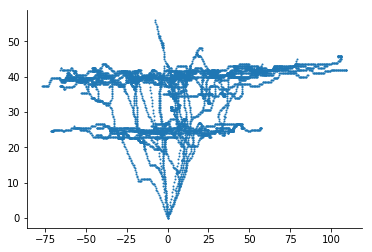

In [8]:
swc = pd.read_csv(path, delim_whitespace=True, comment='#',
                                  names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)
mytree = nt.NeuronTree(swc=swc, nxversion=1)

dist = 1  # in microns
# get the resampled point could along each neurite at distance 1 micron.
# pc is an array of 3D coordinates for each resampled node
pc = mytree.resample_nodes(mytree.get_graph(), dist)
plt.figure()
plt.scatter(pc[:, 0], pc[:, 2], s=1)
sns.despine()

In [15]:
 
def _project_data(proj_axes, data):
    """
        Helper function to project data onto the the axes defined in proj_axes.
        
        :param proj_axes:   str that holds the axes that are projected to as number, e.g. '01' for projection onto xy
                            or '02' for projection onto xz.
    """

    p_a = proj_axes
    dim = len(proj_axes)
    
    if dim == 2:
        indices = '012'
        for ix in range(len(p_a)):
            indices = indices.replace(p_a[ix], '')
        deleted_axis = int(indices)
        ax = [0, 1, 2]
        ax.remove(deleted_axis)
        result = data[:, ax]

    elif dim == 1:

        ax = int(p_a)
        result = data[:, ax]
    else:
        result = data

    return result

In [28]:
###### PARAMETER ################
# r holds the normalization bounds. They could be read in through the config.
r= dict(min=np.min(pc, axis=0),max=np.max(pc, axis=0))


# which axes to project on
proj_axes = '02'
dim = len(proj_axes)
n_bins = 100


# whether the density map is to be smoothed
smooth = True
sigma =2



######## COMPUTATION ############

# normalize point cloud
pc = (pc - r['min']) / (r['max'] - r['min'])

# holds the range for binning of the histogram. So far the cells are noramlized to be between max --> 1 and min --> 0
# I can therefore know, that the point will lie between 0 and 1. However, the range could also be a parameter set 
# in the config file.
range_ = [[-.1, 1.1]] * dim
data = _project_data(proj_axes, pc)


# compute histogram hence density map
H_100, edges = np.histogramdd(data, bins=(n_bins,) * dim,
                      range=range_, normed=True)

H_20, edges_20 = np.histogramdd(data, bins=(20,) * dim,
                      range=range_, normed=True)


H_10, edges_10 = np.histogramdd(data, bins=(10,) * dim,
                      range=range_, normed=True)

# perform smoothing
if smooth:
    H_100 = smooth_gaussian(H_100, dim=dim, sigma=sigma)
    H_20 = smooth_gaussian(H_20, dim=dim, sigma=sigma)
    H_10 = smooth_gaussian(H_10, dim=dim, sigma=sigma)


Text(0.5,1,'10 bins')

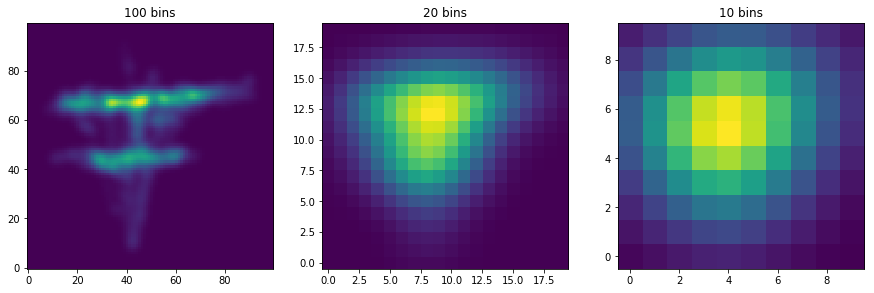

In [43]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(H_100.T)
plt.gca().invert_yaxis()
plt.title('100 bins')

plt.subplot(132)
plt.imshow(H_20.T)
plt.gca().invert_yaxis()
plt.title('20 bins')

plt.subplot(133)
plt.imshow(H_10.T)
plt.gca().invert_yaxis()
plt.title('10 bins')

## 1D density maps

In [44]:
pc = mytree.resample_nodes(mytree.get_graph(), dist)

# normalize point cloud
pc = (pc - r['min']) / (r['max'] - r['min'])

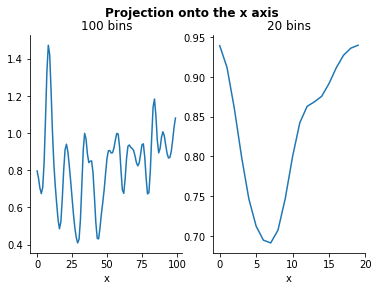

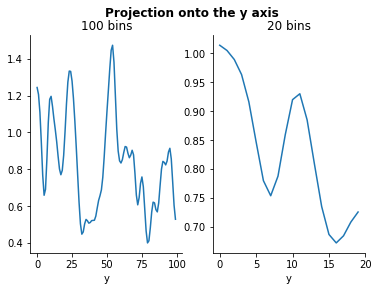

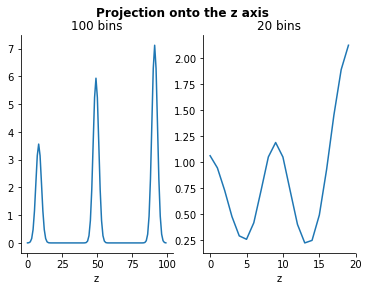

In [47]:
# whether the density map is to be smoothed
smooth = True
sigma =2

for proj_axes, ax in [('0','x'), ('1','y'), ('2','z')]:

    plt.figure()
    dim = len(proj_axes)
    

    range_ = [[-.1, 1.1]] * dim
    data = _project_data(proj_axes, pc)

    for k,n_bins in enumerate([100,20]):
        # compute histogram hence density map
        H, edges = np.histogramdd(data, bins=(n_bins,) * dim,
                          range=range_, normed=True)


        # perform smoothing
        if smooth:
            H = smooth_gaussian(H, dim=dim, sigma=sigma)

        plt.subplot(1,2,k+1)
        plt.plot(H)
        sns.despine()
        plt.xlabel(ax)
        plt.title('%i bins'%n_bins)

    plt.suptitle('Projection onto the %s axis'%ax, weight='bold')